In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ipywidgets import *
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [ ]:
# # Execute this code block to install dependencies when running on colab
# try:
#     import torch
# except:
#     from os.path import exists
#     from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#     platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#     cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#     accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#     !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

# try: 
#     import torchbearer
# except:
#     !pip install torchbearer

In [ ]:

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [ ]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [ ]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


In [ ]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size).cuda()
        self.fc2 = nn.Linear(hidden_size, num_classes).cuda()  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        # if not self.training:
        #    out = F.softmax(out, dim=1)
        return out

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_plot, acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # Next two lines enable us to use Binary Crossentropy
                    #outputs = outputs.squeeze(1)
                    #loss = criterion(outputs, labels)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #     phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)
    return model

In [ ]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), facecolor='w', edgecolor='k')
    #plt.tight_layout()
    ax[0].plot(loss_plot, label="Training Loss", color = 'g', linewidth =7)
    ax[0].plot(val_loss_plot, label="Test Loss", color = 'r', linewidth =7)
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_title("Training/Test Loss", fontsize=20);
    ax[0].set_xlabel("Epochs", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training accuracy", color = 'g', linewidth =7)
    ax[1].plot(val_acc_plot, label="Test accuracy", color = 'r', linewidth =7)
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_title("Training/Test Accuracy", fontsize=20);
    ax[1].set_xlabel("Epochs", fontsize=18);
    ax[1].set_ylabel("Accuracy ", fontsize=18);
    plt.savefig("Training.png", format='png', dpi=1200)
    plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

BaselineModel(
  (fc1): Linear(in_features=784, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.892900
Best val Loss: 0.379484


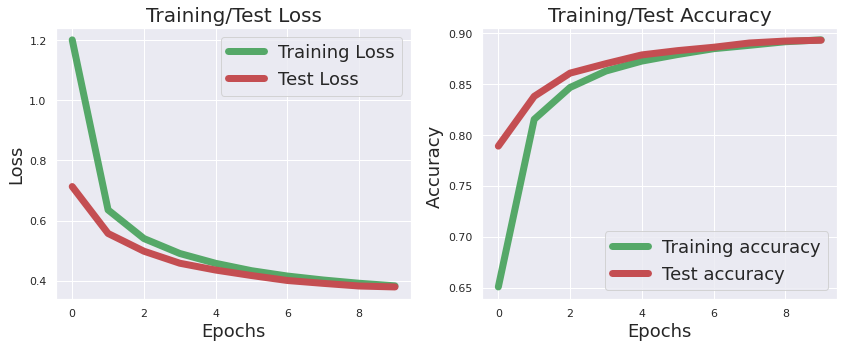

BaselineModel(
  (fc1): Linear(in_features=784, out_features=55, bias=True)
  (fc2): Linear(in_features=55, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.969600
Best val Loss: 0.096926


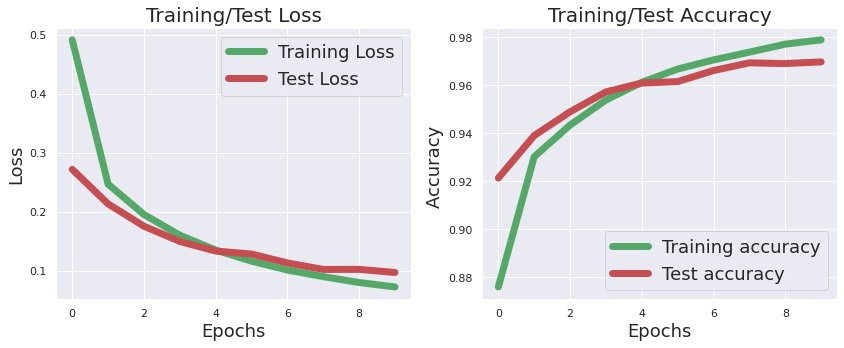

BaselineModel(
  (fc1): Linear(in_features=784, out_features=105, bias=True)
  (fc2): Linear(in_features=105, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.976900
Best val Loss: 0.075496


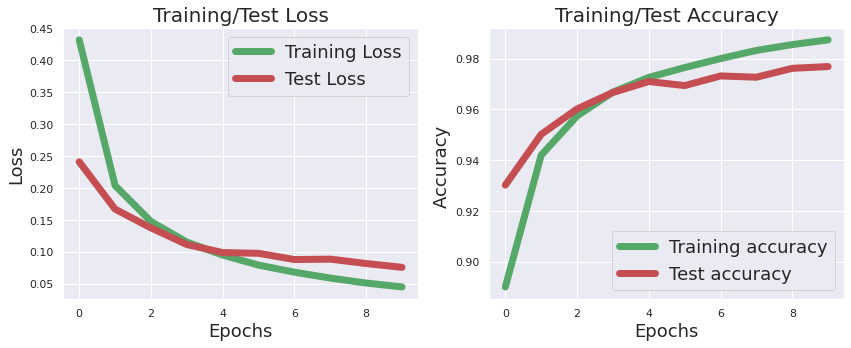

BaselineModel(
  (fc1): Linear(in_features=784, out_features=155, bias=True)
  (fc2): Linear(in_features=155, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.978300
Best val Loss: 0.071068


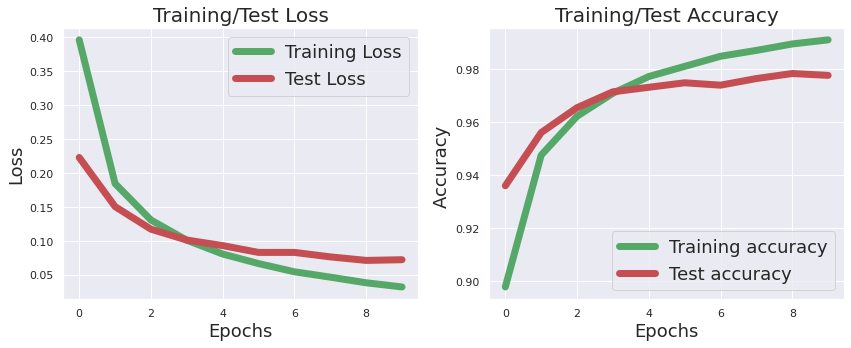

BaselineModel(
  (fc1): Linear(in_features=784, out_features=205, bias=True)
  (fc2): Linear(in_features=205, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.977300
Best val Loss: 0.074441


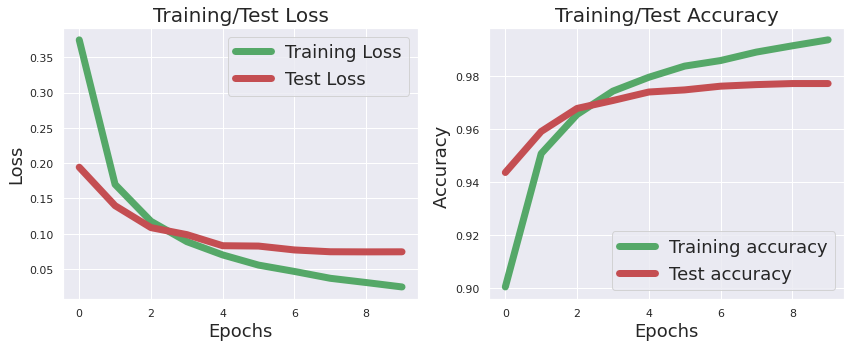

BaselineModel(
  (fc1): Linear(in_features=784, out_features=255, bias=True)
  (fc2): Linear(in_features=255, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.979000
Best val Loss: 0.067958


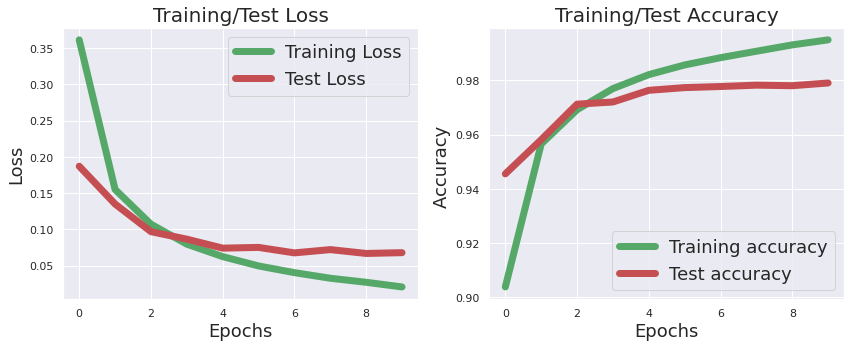

BaselineModel(
  (fc1): Linear(in_features=784, out_features=305, bias=True)
  (fc2): Linear(in_features=305, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.980900
Best val Loss: 0.063835


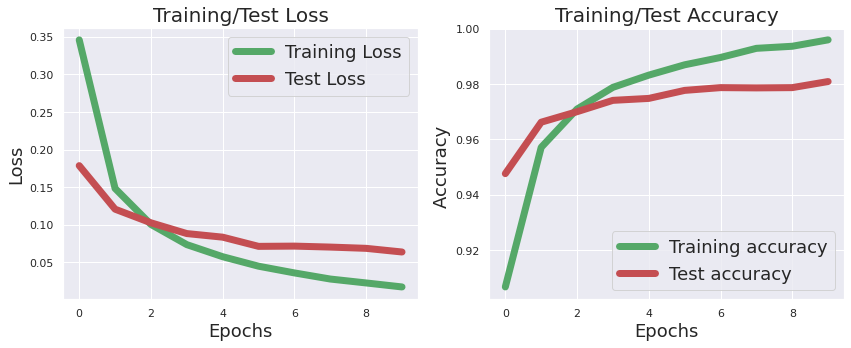

BaselineModel(
  (fc1): Linear(in_features=784, out_features=355, bias=True)
  (fc2): Linear(in_features=355, out_features=10, bias=True)
)
Training complete in 0m 49s
Best val Acc: 0.982800
Best val Loss: 0.059365


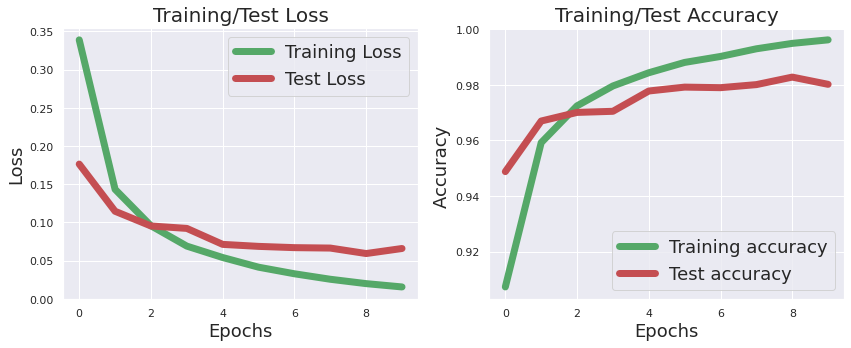

BaselineModel(
  (fc1): Linear(in_features=784, out_features=405, bias=True)
  (fc2): Linear(in_features=405, out_features=10, bias=True)
)
Training complete in 0m 50s
Best val Acc: 0.980600
Best val Loss: 0.062213


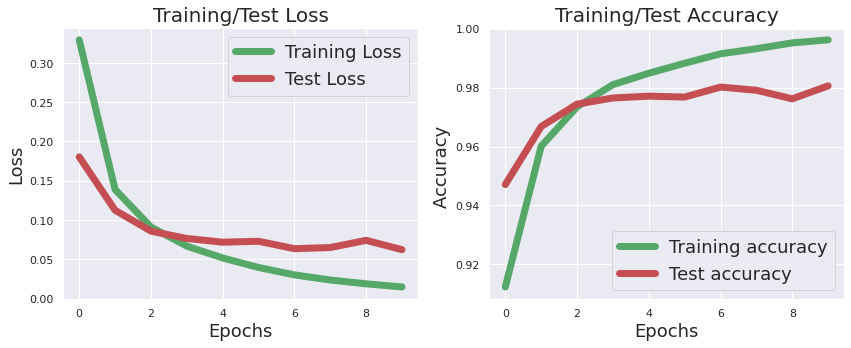

BaselineModel(
  (fc1): Linear(in_features=784, out_features=455, bias=True)
  (fc2): Linear(in_features=455, out_features=10, bias=True)
)
Training complete in 0m 49s
Best val Acc: 0.980800
Best val Loss: 0.061479


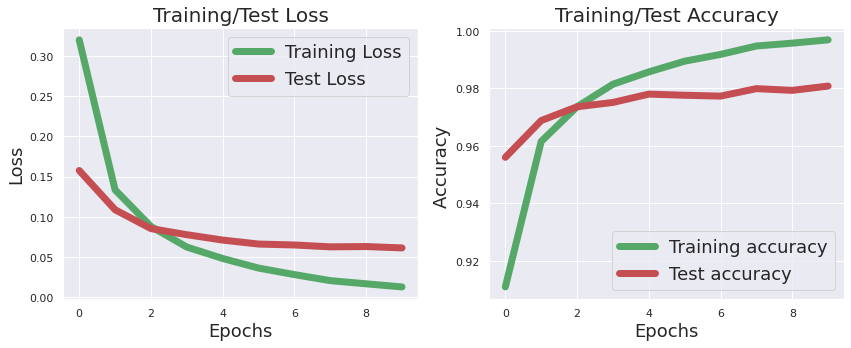

In [ ]:
import time
import copy

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in range(5, 500, 50):
      model = BaselineModel(784, i, 10)
      print(model)
      criterion = nn.CrossEntropyLoss()
      optimizer_ft = optim.Adam(model.parameters())
      train_model(model, criterion, optimizer_ft, num_epochs=10).to(device)

BaselineModel(
  (fc1): Linear(in_features=784, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=50, bias=True)
)
Training complete in 0m 57s
Best val Acc: 0.981800
Best val Loss: 0.066686


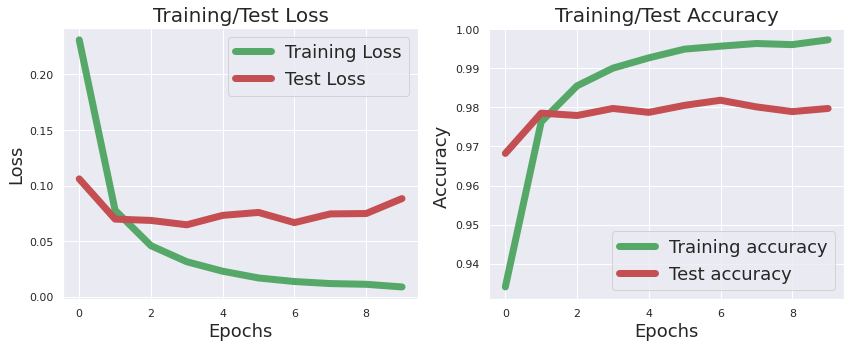

BaselineModel(
  (fc1): Linear(in_features=784, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=50, bias=True)
)

In [ ]:

model = BaselineModel(784, 5000, 50)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=10).to(device)

BaselineModel(
  (fc1): Linear(in_features=784, out_features=250000, bias=True)
  (fc2): Linear(in_features=250000, out_features=10, bias=True)
)
Training complete in 8m 59s
Best val Acc: 0.983500
Best val Loss: 0.104720


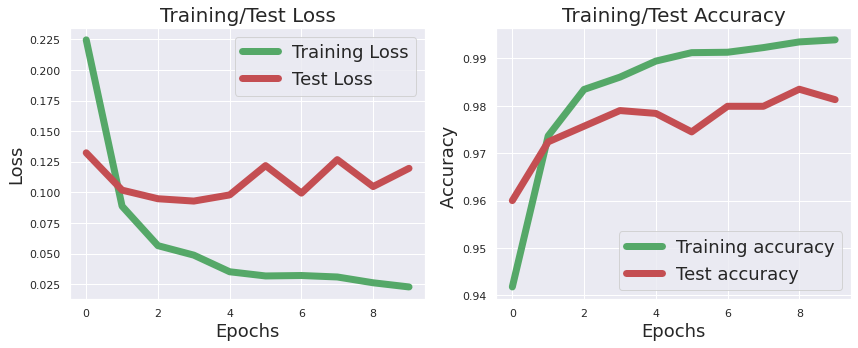

BaselineModel(
  (fc1): Linear(in_features=784, out_features=250000, bias=True)
  (fc2): Linear(in_features=250000, out_features=10, bias=True)
)

In [ ]:
model = BaselineModel(784, 250000, 10)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=10).to(device)

BaselineModel(
  (fc1): Linear(in_features=784, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.776800
Best val Loss: 0.752369


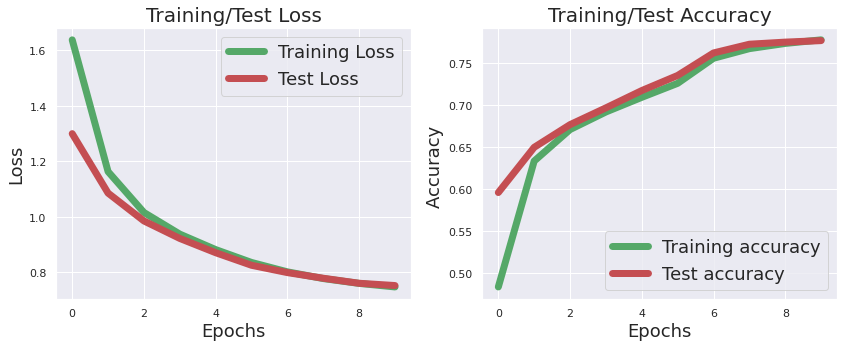

BaselineModel(
  (fc1): Linear(in_features=784, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.891700
Best val Loss: 0.375942


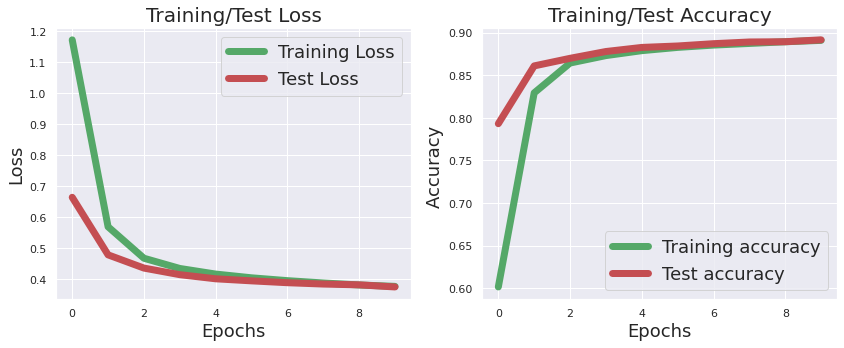

BaselineModel(
  (fc1): Linear(in_features=784, out_features=9, bias=True)
  (fc2): Linear(in_features=9, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.923600
Best val Loss: 0.273319


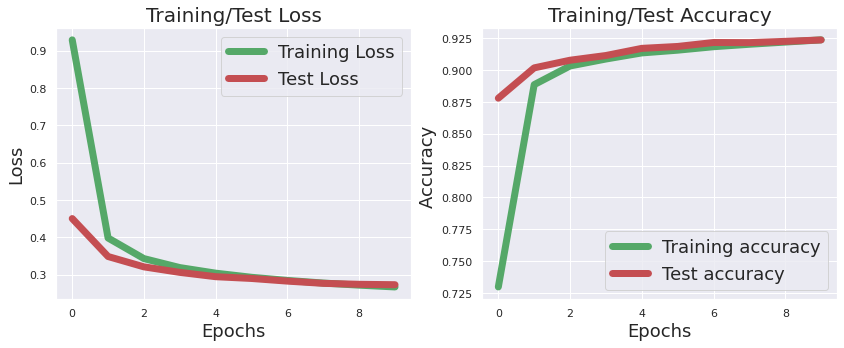

BaselineModel(
  (fc1): Linear(in_features=784, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.938400
Best val Loss: 0.212949


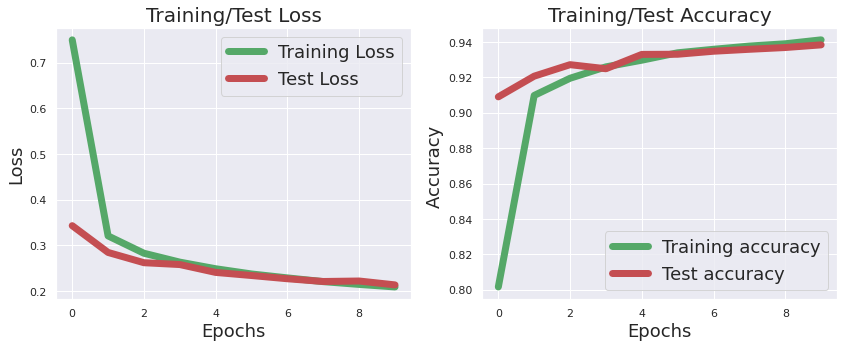

BaselineModel(
  (fc1): Linear(in_features=784, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.943400
Best val Loss: 0.193934


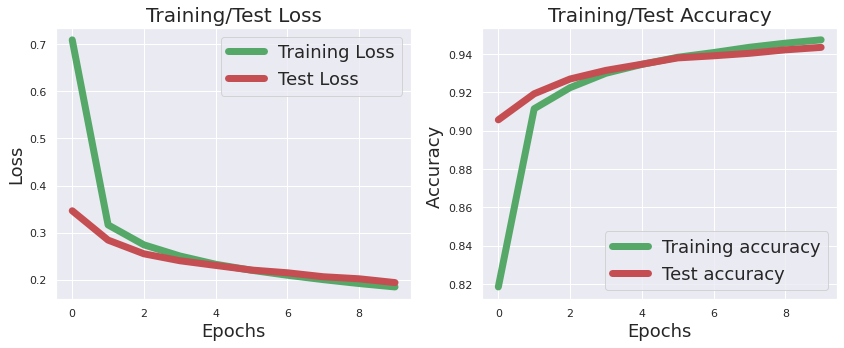

BaselineModel(
  (fc1): Linear(in_features=784, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.947800
Best val Loss: 0.182412


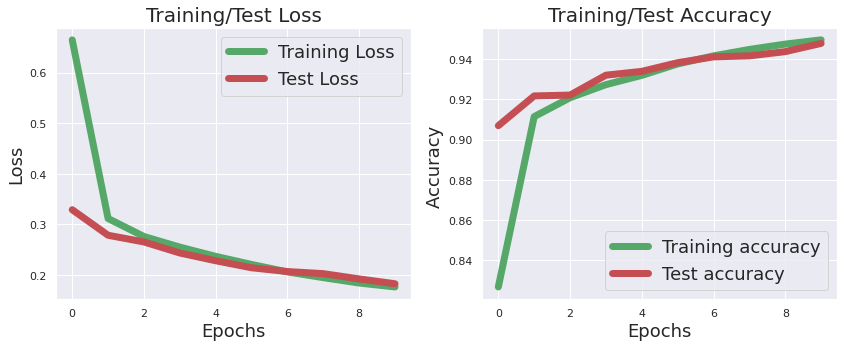

BaselineModel(
  (fc1): Linear(in_features=784, out_features=21, bias=True)
  (fc2): Linear(in_features=21, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.950800
Best val Loss: 0.164890


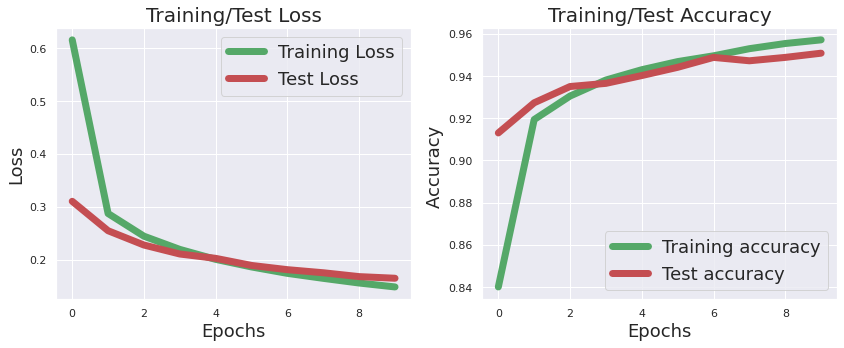

BaselineModel(
  (fc1): Linear(in_features=784, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.953400
Best val Loss: 0.158560


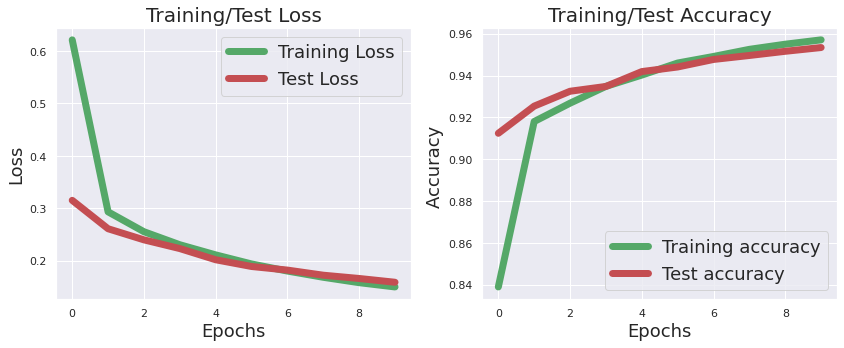

BaselineModel(
  (fc1): Linear(in_features=784, out_features=27, bias=True)
  (fc2): Linear(in_features=27, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.958600
Best val Loss: 0.134835


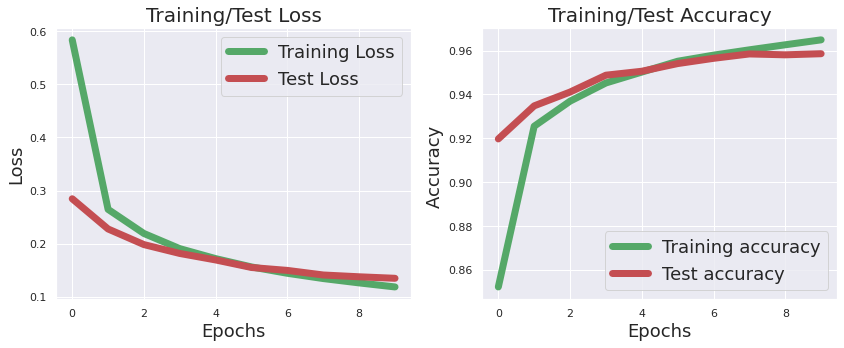

BaselineModel(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.960700
Best val Loss: 0.126231


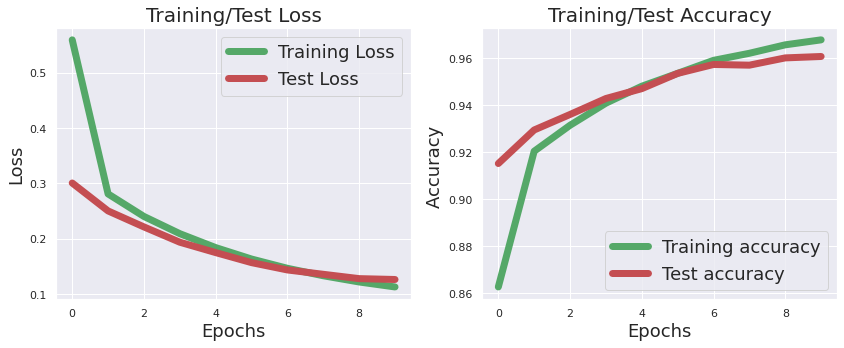

BaselineModel(
  (fc1): Linear(in_features=784, out_features=33, bias=True)
  (fc2): Linear(in_features=33, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.963400
Best val Loss: 0.128284


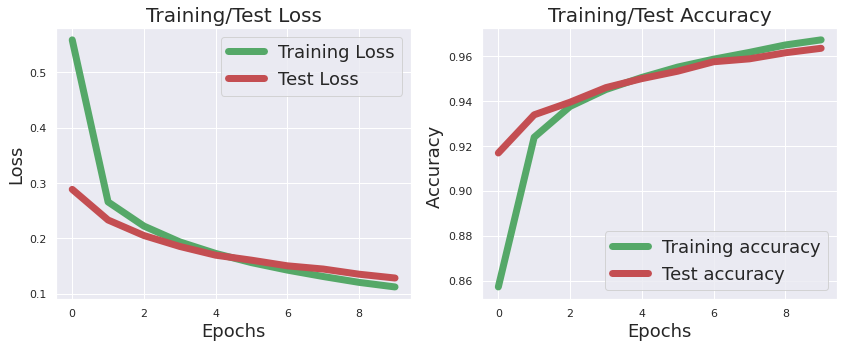

BaselineModel(
  (fc1): Linear(in_features=784, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.965300
Best val Loss: 0.118534


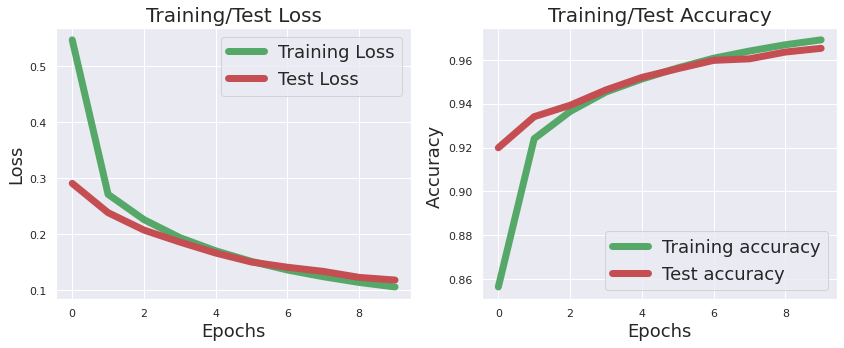

BaselineModel(
  (fc1): Linear(in_features=784, out_features=39, bias=True)
  (fc2): Linear(in_features=39, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.965800
Best val Loss: 0.119194


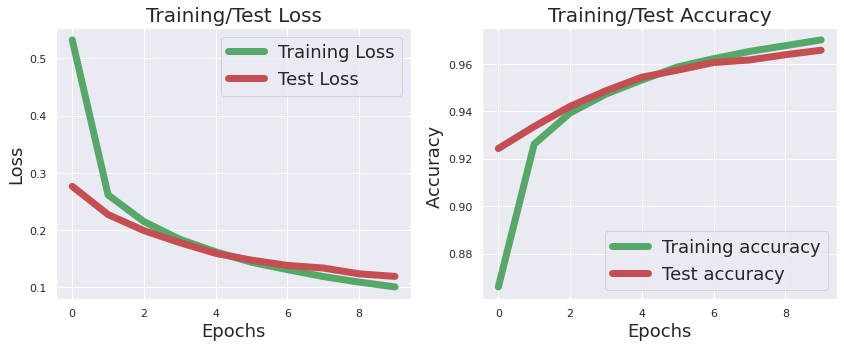

BaselineModel(
  (fc1): Linear(in_features=784, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.965300
Best val Loss: 0.113514


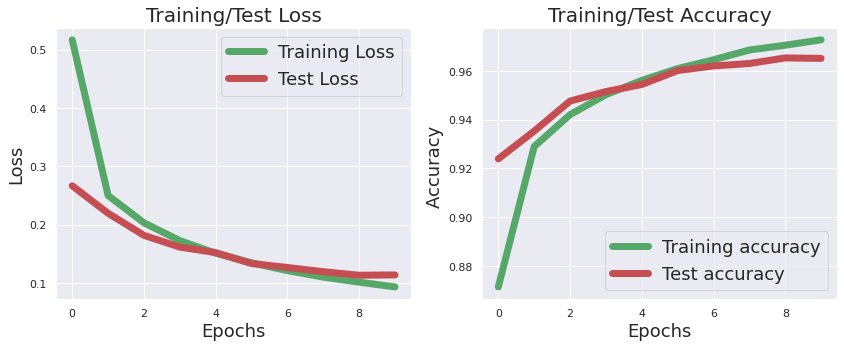

BaselineModel(
  (fc1): Linear(in_features=784, out_features=45, bias=True)
  (fc2): Linear(in_features=45, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.966100
Best val Loss: 0.113225


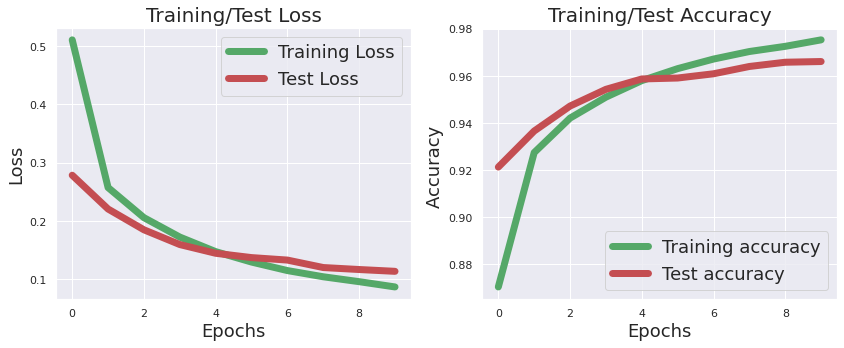

BaselineModel(
  (fc1): Linear(in_features=784, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.969400
Best val Loss: 0.103530


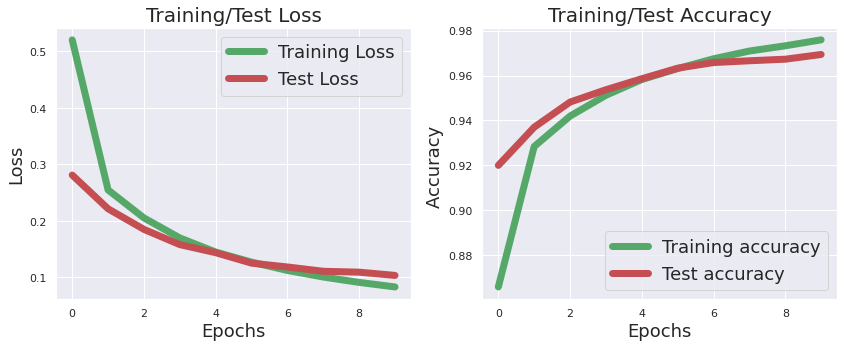

In [ ]:
for i in range(3, 50, 3):
      model = BaselineModel(784, i, 10)
      print(model)
      criterion = nn.CrossEntropyLoss()
      optimizer_ft = optim.Adam(model.parameters())
      train_model(model, criterion, optimizer_ft, num_epochs=10).to(device)

In [ ]:
def test_model(model, testloader):
    model.eval()
    # Computing the model accuracy on the test set
    correct, total = 0, 0
    for x, y in testloader:
        outputs = model(x.cuda())
        winners = outputs.argmax(dim=1)
        count = [1 for i, j in zip(winners, y.cuda().long()) if i == j]
        correct += sum(count)
        total += len(y)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    
test_model(model, testloader)

Test Accuracy: 96.94 %


In [ ]:
def confusion_matrix(data, nb_classes):
    df_cm = pd.DataFrame(data, 
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', 
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    #plt.savefig("confusion_matrix.png", format='png', dpi=1200)
    plt.show()

# ! pip install PTable
# from prettytable import PrettyTable
def summary_table(data, nb_classes):
    p = PrettyTable(data)
    p.title = 'Predicted Output'
    for head, row in zip([i for i in range(0, nb_classes)], data):
        r = [head]
        r.extend(row)
        p.add_row(r)
    l = ['    ']
    l.extend([i for i in range(0, nb_classes)])
    p.field_names = l
    print(p)

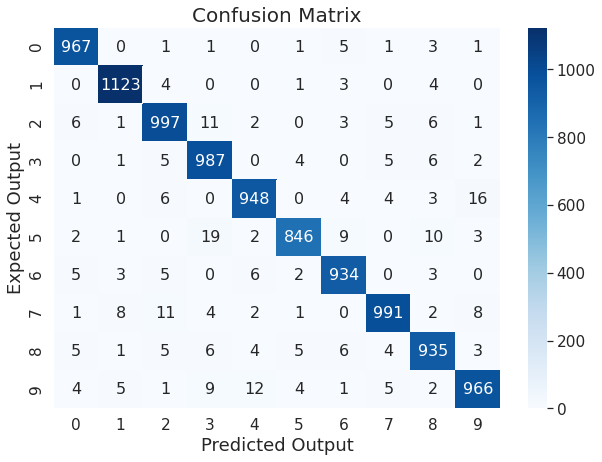

Class: 0 Accuracy: 98.67347
Class: 1 Accuracy: 98.94273
Class: 2 Accuracy: 96.60853
Class: 3 Accuracy: 97.72277
Class: 4 Accuracy: 96.53768
Class: 5 Accuracy: 94.84305
Class: 6 Accuracy: 97.49478
Class: 7 Accuracy: 96.40078
Class: 8 Accuracy: 95.995895
Class: 9 Accuracy: 95.73836
Overall Accuracy:  96.8958 %


In [ ]:
def acc_per_class(model, testloader, nb_classes):
      model.eval()
      confusion_mat = torch.zeros(nb_classes, nb_classes)
      class_correct = torch.zeros(10)
      class_total = torch.zeros(10)
      total = 0
      for inputs, labels in testloader:
          outputs = model(inputs.cuda())
          _, preds = torch.max(outputs, 1)
          for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_mat[t.long(), p.long()] += 1

      confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes)

      per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
      for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
      acc = torch.mean(per_class_acc).data.cpu().numpy()
      print("Overall Accuracy: ", acc, "%")

acc_per_class(model, testloader, 10)

In [ ]:
def train_model_hidden(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_plot, acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    #train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)
    return model, loss_plot, val_loss_plot, acc_plot, val_acc_plot

In [ ]:
import time
import copy

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
t_l, v_l, t_a, v_a = [], [], [], []
for i in range(5, 1000, 100):
      model = BaselineModel(784, i, 10)
      print(model)
      criterion = nn.CrossEntropyLoss()
      optimizer_ft = optim.Adam(model.parameters())
      _, loss_plot, val_loss_plot, acc_plot, val_acc_plot = train_model_hidden(model, criterion, optimizer_ft, num_epochs=10)
      t_l.append(loss_plot[len(loss_plot)-1])
      v_l.append(val_loss_plot[len(val_loss_plot)-1])
      t_a.append(acc_plot[len(acc_plot)-1])
      v_a.append(val_acc_plot[len(val_acc_plot)-1])

BaselineModel(
  (fc1): Linear(in_features=784, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.876800
Best val Loss: 0.424372
BaselineModel(
  (fc1): Linear(in_features=784, out_features=105, bias=True)
  (fc2): Linear(in_features=105, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.977000
Best val Loss: 0.077278
BaselineModel(
  (fc1): Linear(in_features=784, out_features=205, bias=True)
  (fc2): Linear(in_features=205, out_features=10, bias=True)
)
Training complete in 0m 48s
Best val Acc: 0.979400
Best val Loss: 0.070086
BaselineModel(
  (fc1): Linear(in_features=784, out_features=305, bias=True)
  (fc2): Linear(in_features=305, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.981300
Best val Loss: 0.061027
BaselineModel(
  (fc1): Linear(in_features=784, out_features=405, bias=True)
  (fc2): Linear(in_features=405, out_features=10, bias=True)
)
Trai

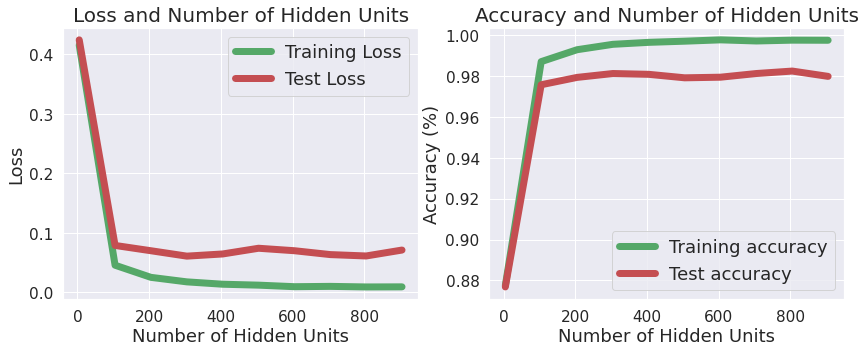

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# plt.tight_layout()
l = [i for i in range(5, 1000, 100)]
ax[0].plot(l, t_l, label="Training Loss", color = 'g', linewidth =7)
ax[0].plot(l, v_l, label="Test Loss", color = 'r', linewidth =7)
ax[0].legend(fontsize=18)
ax[0].grid(True)
ax[0].set_title("Loss and Number of Hidden Units", fontsize=20);
ax[0].set_xlabel("Number of Hidden Units", fontsize=18);
ax[0].set_ylabel("Loss", fontsize=18);
ax[1].plot(l, t_a, label="Training accuracy", color = 'g', linewidth =7)
ax[1].plot(l, v_a, label="Test accuracy", color = 'r', linewidth =7)
ax[1].legend(fontsize=18)
ax[1].grid(True)
ax[1].set_title("Accuracy and Number of Hidden Units", fontsize=20);
ax[1].set_xlabel("Number of Hidden Units", fontsize=18);
ax[1].set_ylabel("Accuracy (%)", fontsize=18);
plt.savefig("Hidden_Units.png", format='png', dpi=1200)
plt.show()

In [ ]:
import time
import copy

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
t_l, v_l, t_a, v_a = [], [], [], []
for i in range(1, 200, 5):
      model = BaselineModel(784, i, 10)
      print(model)
      criterion = nn.CrossEntropyLoss()
      optimizer_ft = optim.Adam(model.parameters())
      _, loss_plot, val_loss_plot, acc_plot, val_acc_plot = train_model_hidden(model, criterion, optimizer_ft, num_epochs=10)
      t_l.append(loss_plot[len(loss_plot)-1])
      v_l.append(val_loss_plot[len(val_loss_plot)-1])
      t_a.append(acc_plot[len(acc_plot)-1])
      v_a.append(val_acc_plot[len(val_acc_plot)-1])

BaselineModel(
  (fc1): Linear(in_features=784, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.345500
Best val Loss: 1.688865
BaselineModel(
  (fc1): Linear(in_features=784, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.901000
Best val Loss: 0.349611
BaselineModel(
  (fc1): Linear(in_features=784, out_features=11, bias=True)
  (fc2): Linear(in_features=11, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.932200
Best val Loss: 0.242587
BaselineModel(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.947000
Best val Loss: 0.181204
BaselineModel(
  (fc1): Linear(in_features=784, out_features=21, bias=True)
  (fc2): Linear(in_features=21, out_features=10, bias=True)
)
Training compl

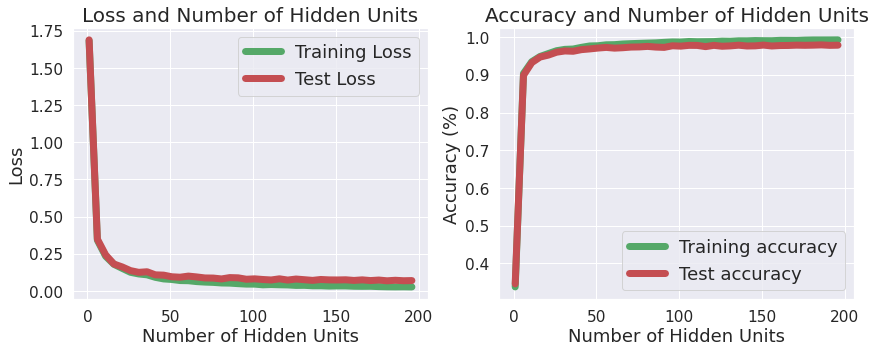

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# plt.tight_layout()
l = [i for i in range(1, 200, 5)]
ax[0].plot(l, t_l, label="Training Loss", color = 'g', linewidth =7)
ax[0].plot(l, v_l, label="Test Loss", color = 'r', linewidth =7)
ax[0].legend(fontsize=18)
ax[0].grid(True)
ax[0].set_title("Loss and Number of Hidden Units", fontsize=20);
ax[0].set_xlabel("Number of Hidden Units", fontsize=18);
ax[0].set_ylabel("Loss", fontsize=18);
ax[1].plot(l, t_a, label="Training accuracy", color = 'g', linewidth =7)
ax[1].plot(l, v_a, label="Test accuracy", color = 'r', linewidth =7)
ax[1].legend(fontsize=18)
ax[1].grid(True)
ax[1].set_title("Accuracy and Number of Hidden Units", fontsize=20);
ax[1].set_xlabel("Number of Hidden Units", fontsize=18);
ax[1].set_ylabel("Accuracy (%)", fontsize=18);
plt.savefig("Closeup_Hidden_Units.png", format='png', dpi=1200)
plt.show()

In [ ]:
import time
import copy

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
t_l, v_l, t_a, v_a = [], [], [], []
for i in range(5, 300000, 50000):
      model = BaselineModel(784, i, 10)
      print(model)
      criterion = nn.CrossEntropyLoss()
      optimizer_ft = optim.Adam(model.parameters())
      _, loss_plot, val_loss_plot, acc_plot, val_acc_plot = train_model_hidden(model, criterion, optimizer_ft, num_epochs=10)
      t_l.append(loss_plot[len(loss_plot)-1])
      v_l.append(val_loss_plot[len(val_loss_plot)-1])
      t_a.append(acc_plot[len(acc_plot)-1])
      v_a.append(val_acc_plot[len(val_acc_plot)-1])

BaselineModel(
  (fc1): Linear(in_features=784, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
)
Training complete in 0m 47s
Best val Acc: 0.890400
Best val Loss: 0.391230
BaselineModel(
  (fc1): Linear(in_features=784, out_features=50005, bias=True)
  (fc2): Linear(in_features=50005, out_features=10, bias=True)
)
Training complete in 2m 22s
Best val Acc: 0.982600
Best val Loss: 0.099832
BaselineModel(
  (fc1): Linear(in_features=784, out_features=100005, bias=True)
  (fc2): Linear(in_features=100005, out_features=10, bias=True)
)
Training complete in 4m 1s
Best val Acc: 0.983800
Best val Loss: 0.077755
BaselineModel(
  (fc1): Linear(in_features=784, out_features=150005, bias=True)
  (fc2): Linear(in_features=150005, out_features=10, bias=True)
)
Training complete in 5m 40s
Best val Acc: 0.981800
Best val Loss: 0.095822
BaselineModel(
  (fc1): Linear(in_features=784, out_features=200005, bias=True)
  (fc2): Linear(in_features=200005, out_features=

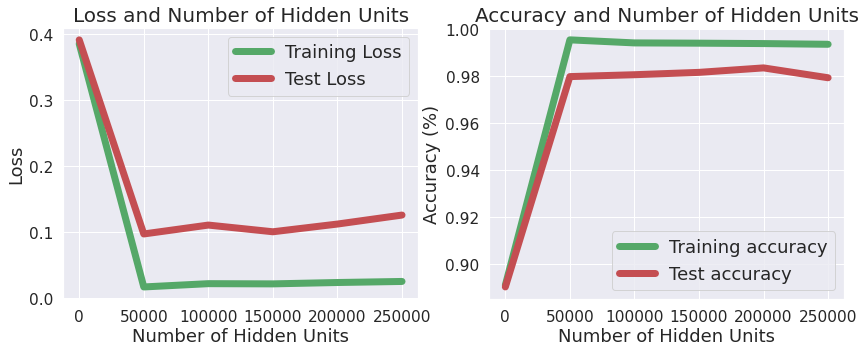

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# plt.tight_layout()
l = [i for i in range(5, 300000, 50000)]
ax[0].plot(l, t_l, label="Training Loss", color = 'g', linewidth =7)
ax[0].plot(l, v_l, label="Test Loss", color = 'r', linewidth =7)
ax[0].legend(fontsize=18)
ax[0].grid(True)
ax[0].set_title("Loss and Number of Hidden Units", fontsize=20);
ax[0].set_xlabel("Number of Hidden Units", fontsize=18);
ax[0].set_ylabel("Loss", fontsize=18);
ax[1].plot(l, t_a, label="Training accuracy", color = 'g', linewidth =7)
ax[1].plot(l, v_a, label="Test accuracy", color = 'r', linewidth =7)
ax[1].legend(fontsize=18)
ax[1].grid(True)
ax[1].set_title("Accuracy and Number of Hidden Units", fontsize=20);
ax[1].set_xlabel("Number of Hidden Units", fontsize=18);
ax[1].set_ylabel("Accuracy (%)", fontsize=18);
plt.savefig("Full_Hidden_Units.png", format='png', dpi=1200)
plt.show()

Training complete in 0m 47s
Best val Acc: 0.948100
Best val Loss: 0.173413


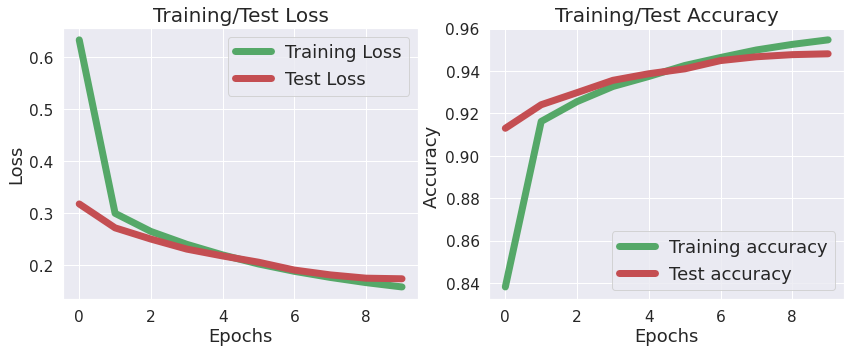

BaselineModel(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)

In [ ]:

import time
import copy

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BaselineModel(784, 20, 10)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=10)

Training complete in 1m 32s
Best val Acc: 0.982000
Best val Loss: 0.071001


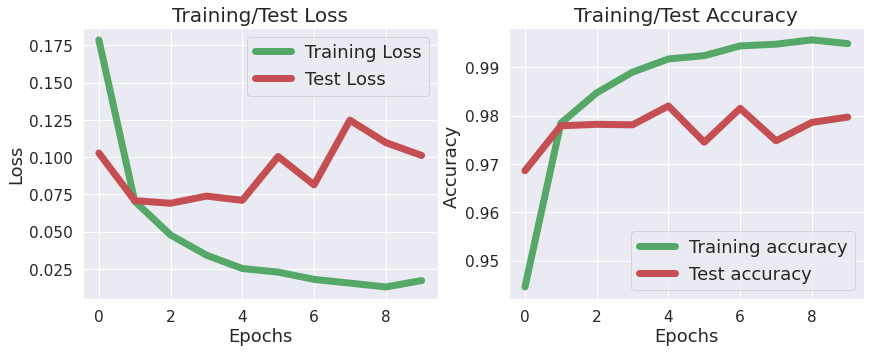

BaselineModel(
  (fc1): Linear(in_features=784, out_features=25000, bias=True)
  (fc2): Linear(in_features=25000, out_features=10, bias=True)
)

In [ ]:
import time
import copy

dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BaselineModel(784, 25000, 10)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=10)